In [4]:
fdir = "../scripts/hanglog/junk1"

import os, sys
sys.path.append("..")
import hacktrack.loaders
import pandas, numpy
from matplotlib import pyplot as plt
from hacktrack import loaders, utils
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

logfiles = os.listdir(fdir)
print(logfiles)
fLog = os.path.join(fdir, logfiles[0])
fd = loaders.FlyDat(fLog)
fd.LoadC("ZY")

t0 = pandas.Timestamp('2020-12-26 17:47:33')
t1 = t0 + pandas.Timedelta("9s")
pZ = fd.pZ[~fd.pZ.bad][t0:t1]

['hdata-2020-12-26_17-47-06.log']
Extracting knowndate from filename: 2020-12-26
badline End(17944,4948)

Y:8889, Z:9030, U:23, aA:4337, aZ:310, aF:300
linAdifftime 3669.815751445087 count 692
Made for Q 0 last index 0
Made for V 0 last index 0
Loading aQV as no pQV records
Made for aQ 0 last index 0
Made for aV 0 last index 0
Missing GPS data, so setting t0 to 2020-12-26 17:43:44.784816
Made for Z 9030 last index 9030
Warning, using guessed (not GPS) timing corrected value on Z 9030
pCattrname pZ
Made for Y 8889 last index 8889
Warning, using guessed (not GPS) timing corrected value on Y 8889
pCattrname pY


In [6]:
# find the transform that best constrains to XZ plane
import scipy.optimize
from hacktrack.utils import qvec, qmult

def fun(x):
    qa = (1,x[0],x[1],x[2])
    a = (0,0,1)
    rx, ry, rz = qvec(qmult(qa, (pZ.q0, pZ.q1, pZ.q2, pZ.q3)), a)
    res = sum(ry**2)
    return res
g = scipy.optimize.minimize(fun, (0,0,0), method="BFGS") 
g

      fun: 0.0033801492319821
 hess_inv: array([[ 0.00016705, -0.00012781,  0.00013899],
       [-0.00012781,  0.00075542,  0.00014482],
       [ 0.00013899,  0.00014482,  0.0304446 ]])
      jac: array([ 2.13563908e-06, -5.81319910e-07, -5.84986992e-09])
  message: 'Optimization terminated successfully.'
     nfev: 105
      nit: 9
     njev: 21
   status: 0
  success: True
        x: array([-0.00334966,  0.01027928,  0.82260538])

(-0.01554717941473504, 0.006090348938922435, 0.9998605867129919)


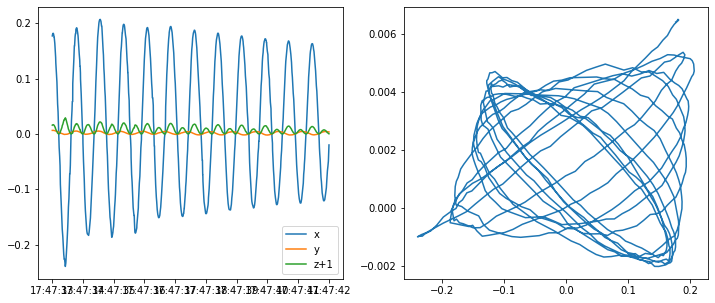

In [12]:
x = g.x
qa = (1,x[0],x[1],x[2])
a = qvec(qa, (0,0,1))
print(a)
rx, ry, rz = qvec(qmult(qa, (pZ.q0, pZ.q1, pZ.q2, pZ.q3)), a)
plt.figure(figsize=(12,5))
fig = plt.subplot(121)
plt.plot(rx, label="x")
plt.plot(ry, label="y")
plt.plot(rz+1, label="z+1")
plt.legend()
fig = plt.subplot(122)
plt.plot(rx, ry)

In [15]:
sec1 = pandas.Timedelta(seconds=1)
def curvefitdifferentiate(rx, ws):
    rx0 = rx.copy()
    rx1 = rx.copy()
    rx2 = rx.copy()
    wt = ws*sec1
    for n in range(len(rx)):
        t = rx.index[n]
        lx = rx[t-wt:t+wt]
        ts = (lx.index - t)/sec1
        weights = 1/((abs(ts)/ws)**2+1)
        pm = numpy.polyfit(ts, lx, deg=3, w=weights)
        rx0.iloc[n] = numpy.polyval(pm, 0)
        pm1 = numpy.polyder(pm)
        rx1.iloc[n] = numpy.polyval(pm1, 0)
        pm2 = numpy.polyder(pm, 2)
        rx2.iloc[n] = numpy.polyval(pm2, 0)
    return rx0, rx1, rx2


In [16]:
rx0, rx1, rx2 = curvefitdifferentiate(rx, 0.18)

[-59.16194992   0.82786564]
x'' = -g sin(theta);  x = r sin(theta);  therefore  slope=-g/(pendulum length)
pendulum length =  0.1658215010141988 m
If the coordinate frame were properly centred, then this ratio could be determined at every timestep


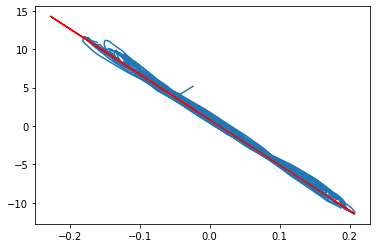

In [31]:
i0, i1 = 100, len(rx0)
plt.plot(rx0.iloc[i0:i1], rx2.iloc[i0:i1])
linear_model = numpy.polyfit(rx0,rx2,1)
linear_model_fn = numpy.poly1d(linear_model)
plt.plot(rx0, linear_model_fn(rx0), color="red")
print(linear_model)
print("x'' = -g sin(theta);  x = r sin(theta);  therefore  slope=-g/(pendulum length)")
print("pendulum length = ", 9.81/59.16, "m")
print("If the coordinate frame were properly centred, then this ratio could be determined at every timestep")